# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

You can use ** Keras ** to implement your model. Read more at [keras.io](https://keras.io/).

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0)). You are not expected to model your architecture precisely using this model nor get the same performance levels, but this is more to show an exampe of an approach used to solve this particular problem. We encourage you to try out different architectures for yourself and see what works best for you. Here is a useful [forum post](https://discussions.udacity.com/t/goodfellow-et-al-2013-architecture/202363) discussing the architecture as described in the paper and here is [another one](https://discussions.udacity.com/t/what-loss-function-to-use-for-multi-digit-svhn-training/176897) discussing the loss function.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
np.random.seed(41)
### Your code implementation goes here.
### Feel free to use as many code cells as needed.


Using TensorFlow backend.


4


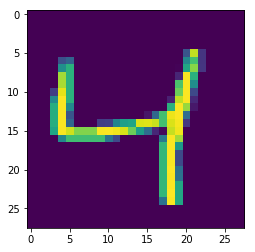

In [2]:
from keras.datasets import mnist
(image_train, label_train), (image_test, label_test)  =mnist.load_data()
plt.figure()
plt.imshow(image_train[2, :, :])
print label_train[2]

In [3]:
print label_train.shape

(60000,)


In [4]:
print image_train.shape[0]
print image_test.shape[0]

60000
10000


In [5]:
"""Input"""


def im_merge(im_in, label_in, num_out, max_num):
    data = np.ndarray(shape=(num_out,28,140))
    labels = np.ndarray(shape=(num_out,5))
    for ctr in range(0,num_out):
        im_list = []
        label_list=[]
        arr_len = im_in.shape[0]
        num_dig = np.random.randint(3,max_num+1)
        for itr in range(0,num_dig):
            index = np.random.randint(0,arr_len)
            im_list.append(im_in[index,:,:])
            label_list.append(label_in[index])
        concat = np.concatenate(im_list, axis=1)
        full_im = np.zeros((28,140))
        full_im[:,0:28*num_dig] += concat
        data[ctr]= full_im
        full_label = np.empty(5)
        full_label.fill(10)
        full_label[0:num_dig] = label_list
        labels[ctr] = full_label
    return data , labels

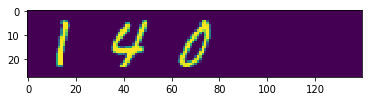

In [6]:
num_train = 20000
num_test = 2000
max_num = 5
train_data, label_train = im_merge(image_train, label_train, num_train, max_num)
test_data, label_test = im_merge(image_test, label_test, num_test, max_num)
plt.figure()
plt.imshow(train_data[2])
train_data = train_data/255
test_data = test_data/255
train_data = train_data.reshape(train_data.shape[0],1,train_data.shape[1],train_data.shape[2])
test_data = test_data.reshape(test_data.shape[0],1,test_data.shape[1],test_data.shape[2]).astype('float32')


In [7]:
print train_data.shape

(20000, 1, 28, 140)


In [8]:
from keras.utils import np_utils
hot_train = np.zeros((num_train,max_num,11))
hot_test = np.zeros((num_test,max_num,11))
for digit in range(0,len(label_train[0])):
    hot_train[:,digit,:] = np_utils.to_categorical(label_train[:,digit],11)
    hot_test[:,digit,:] = np_utils.to_categorical(label_test[:,digit],11)
print label_train[2],hot_train[2]

[  1.   4.   0.  10.  10.] [[ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


In [9]:
train_list = []
test_list = []
for itr in range(0,5):
    train_list.append(hot_train[:,itr,:])
    test_list.append(hot_test[:,itr,:])


In [2]:
from keras.models import Model
from keras.layers import Dense, Input, merge, Convolution2D, MaxPooling2D
from keras.layers import Dropout, Flatten

In [12]:
def base_mod(num_outs):
    inputs=Input(shape=(3920,))
    x = Dense(3920, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    outputs = []
    for itr in range(0,num_outs):
        outputs.append(Dense(11, activation='softmax')(x))
    model = Model(input=inputs, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [31]:
def inception(num_outs):
    input_img=Input(shape=(1,28,140))
    tower_1 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(input_img)
    tower_1 = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(tower_1)

    tower_2 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(input_img)
    tower_2 = Convolution2D(64, 5, 5, border_mode='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), border_mode='same')(input_img)
    tower_3 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(tower_3)

    merged = merge([tower_1, tower_2, tower_3], mode='concat', concat_axis=1)
    
    flat = Flatten()(merged)
    drop = Dropout(0.3)(flat)
    next_rel = Dense(128,activation='relu')(drop)
    outputs = []
    for itr in range(0,num_outs):
        outputs.append(Dense(11, activation='softmax')(next_rel))
    model = Model(input=input_img, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
def large_cnn(num_outs):
    input_img=Input(shape=(1,28,140))
    con1 = Convolution2D(30, 5, 5, border_mode='valid', activation='relu', dim_ordering="th")(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2), dim_ordering="th")(con1)
    con2 = Convolution2D(15, 3, 3, border_mode='valid', activation='relu', dim_ordering="th")(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2), dim_ordering="th")(con2)
    drop = Dropout(0.2)(pool2)
    flat = Flatten()(drop)
    den1 = Dense(128, activation='relu')(flat)
    den2 = Dense(128, activation='relu')(den1)
    outputs = []
    for itr in range(0,num_outs):
        outputs.append(Dense(11, activation='softmax')(den2))
    model = Model(input=input_img, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [12]:
def monster(num_outs):
    input_img=Input(shape=(1,28,140))
    tower_1 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(input_img)
    tower_1 = Convolution2D(64, 3, 3, border_mode='same', activation='relu')(tower_1)

    tower_2 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(input_img)
    tower_2 = Convolution2D(64, 5, 5, border_mode='same', activation='relu')(tower_2)

    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), border_mode='same')(input_img)
    tower_3 = Convolution2D(64, 1, 1, border_mode='same', activation='relu')(tower_3)

    merged = merge([tower_1, tower_2, tower_3], mode='concat', concat_axis=1)
    con1 = Convolution2D(30, 5, 5, border_mode='valid', activation='relu', dim_ordering="th")(merged)
    pool1 = MaxPooling2D(pool_size=(2, 2), dim_ordering="th")(con1)
    con2 = Convolution2D(15, 3, 3, border_mode='valid', activation='relu', dim_ordering="th")(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2), dim_ordering="th")(con2)
    drop = Dropout(0.2)(pool2)
    flat = Flatten()(drop)
    den1 = Dense(128, activation='relu')(flat)
    den2 = Dense(128, activation='relu')(den1)
    outputs = []
    for itr in range(0,num_outs):
        outputs.append(Dense(11, activation='softmax')(den2))
    model = Model(input=input_img, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [32]:
# build the model
inception = inception(5)
# Fit the model
inception.fit(train_data, train_list, nb_epoch=10, batch_size=200, verbose=1)
# Final evaluation of the model
predictions = inception.predict(test_data,batch_size=200, verbose=1)
combined_pred = np.array(predictions).argmax(axis=2).T
print float(np.sum(combined_pred==label_test))/10000

0.9354


In [ ]:
# build the model
conv_net = large_cnn(5)
# Fit the model
conv_net.fit(train_data, train_list, nb_epoch=10, batch_size=200, verbose=1)
# Final evaluation of the model
predictions = conv_net.predict(test_data,batch_size=200, verbose=1)
combined_pred = np.array(predictions).argmax(axis=2).T
equiv = combined_pred==label_test
print 'digit acc' , float(np.sum(equiv))/10000
seq_acc = np.sum((equiv.sum(axis=1)==5))/2000.0
print 'sequence acc' , seq_acc

Epoch 1/10
20000/20000 [==============================] - 420s - loss: 5.8488 - dense_3_loss: 1.3728 - dense_4_loss: 1.3527 - dense_5_loss: 1.3354 - dense_6_loss: 1.0637 - dense_7_loss: 0.7243 - dense_3_acc: 0.5251 - dense_4_acc: 0.5390 - dense_5_acc: 0.5393 - dense_6_acc: 0.6414 - dense_7_acc: 0.7661      

In [13]:
# build the model
model = monster(5)
# Fit the model
model.fit(train_data, train_list, nb_epoch=10, batch_size=200, verbose=1)
# Evaluate the model
predictions = model.predict(test_data,batch_size=200, verbose=1)
combined_pred = np.array(predictions).argmax(axis=2).T
equiv = combined_pred==label_test
print float(np.sum(equiv))/10000
seq_acc = np.sum((equiv.sum(axis=1)==5))/2000.0
print seq_acc

0.9199
0.6605


In [ ]:
print model

### Question 1
_What approach did you take in coming up with a solution to this problem?_

In [115]:
I 

    

0.6482


In [103]:
a = np.arange(6).reshape(2,3)
print a
print np.argmax(a, axis=1)
print a.shape

[[0 1 2]
 [3 4 5]]
[2 2]
(2, 3)


**Answer:** 

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

## Read in file name and bounding box information
Method from Alexander Yau

In [26]:
import numpy as np
import h5py
#Code structure to import .mat file from 
f = h5py.File('train/digitStruct.mat')

data= {}
data['height'] = []
data['label'] = []
data['left'] = []
data['top'] = []
data['width'] = []
data['names'] = []
def get_bbox(name, obj):
    vals = []
    if obj.shape[0] == 1:
        vals.append(obj[0][0])
    else:
        for k in range(obj.shape[0]):
            vals.append(f[obj[k][0]][0][0])
    data[name].append(vals)


for item in f['/digitStruct/bbox']:
    f[item[0]].visititems(get_bbox)
def get_name(index, hdf5_data):
    name = hdf5_data['/digitStruct/name']
    return ''.join([chr(v[0]) for v in hdf5_data[name[index][0]].value])
for index in range(0,f['/digitStruct/name'].shape[0]):
    data['names'].append(get_name(index,f))
#Make labels 5 digits long
for label in data['label']:
    if len(label)<5:
        label+=[0 for item in range(0,5-len(label))]
#find right and bottom of bounding box
for key in data:
    data[key]=np.asarray([np.asarray(obj) for obj in data[key]])
data['right'] =data['left']+data['width']
data['bottom'] = data['top']+data['height']

In [44]:
#data['label']=np.concatenate(data['label'],axis=0)
data['label']=np.reshape(data['label'],(33402,5))

ValueError: cannot reshape array of size 167011 into shape (33402,5)

In [45]:
print data['label'][0:4]
print data['names'][0:4]
print data['left'][0],data['width'][0],data['right'][0]
print len(data['label'])/5.0

[ 1.  9.  0.  0.]
['1.png' '2.png' '3.png' '4.png']
[ 246.  323.] [ 81.  96.] [ 327.  419.]
33402.2


## Image Reader

In [11]:
test = image_read(0,100,data['names'],'train/')
print test[0].shape

(350, 741, 3)


# image data gen

In [15]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        samplewise_center = True,
        samplewise_std_normalization = True,
        fill_mode = 'constant',
        cval=0,
        rescale=1./255,)

In [41]:
print data['label'][0:20]

[ 1.  9.  0.  0.  0.  2.  3.  0.  0.  0.  2.  5.  0.  0.  0.  9.  3.  0.
  0.  0.]


## Train Model

In [37]:
from keras.utils import np_utils
data['hot_label'] = np.zeros((data['label'].shape[0],5,11))
#hot_test = np.zeros((num_test,max_num,11))
for digit in range(0,5):
    data['hot_label'][:,digit,:] = np_utils.to_categorical(data['label'][:,digit],11)
    #hot_test[:,digit,:] = np_utils.to_categorical(label_test[:,digit],11)
print data['hot_label'][2],data['label'][2]


#print hot_train[300],train_labels[211]

IndexError: too many indices for array

In [16]:
def large_cnn(num_outs):
    input_img=Input(shape=(32,32,3))
    con1 = Convolution2D(30, 5, 5, border_mode='valid', activation='relu')(input_img)
    pool1 = MaxPooling2D(pool_size=(2, 2))(con1)
    con2 = Convolution2D(15, 3, 3, border_mode='valid', activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(con2)
    drop = Dropout(0.2)(pool2)
    flat = Flatten()(drop)
    den1 = Dense(128, activation='relu')(flat)
    den2 = Dense(128, activation='relu')(den1)
    outputs = []
    for itr in range(0,num_outs):
        outputs.append(Dense(11, activation='softmax')(den2))
    model = Model(input=input_img, output=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [17]:
# build the model
conv_net = large_cnn(5)
# Fit the model
conv_net.fit_generator(
    datagen, train_list, nb_epoch=10, batch_size=200, verbose=1)

NameError: name 'train_data' is not defined

### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

## IOU
Adrian Rosebrock
http://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

Pixel coordinate refrences may be screwy if errors double check here!

In [ ]:
#Intersection over union
def iou(tt,lt,wt,ht,tg,lg,wg,hg):
    # determine the (x, y)-coordinates of the intersection rectangle
    li = max(lt, lg)
    bi = max(tt-ht, tg-hg)
    ri = min(lt+wt, lg+wg)
    ti = min(tt, tg)

    # compute the area of intersection rectangle
    interArea = (ri - li) * (ti - bi)

    # compute the area of both the prediction and ground-truth
    # rectangles
    train_area = wt*ht+1
    guess_area = wg*hg+1

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(train_area + guess_area - interArea)

    # return the intersection over union value
    return iou

In [ ]:
#Image generator
from scipy import misc


def image_read(start_index, stop_index,name_data, path):
    image_list = []
    for image_name in name_data[start_index:stop_index]:
        
        image_list.append(misc.imread(path+image_name))
    return np.asarray(image_list)
        
        

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.